In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

Lets download the dataset

In [85]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-02-03 17:02:17--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.01s   

2020-02-03 17:02:17 (1.79 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [86]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [87]:
df.shape

(346, 10)

### Convert to date time object 

In [25]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [26]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [27]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


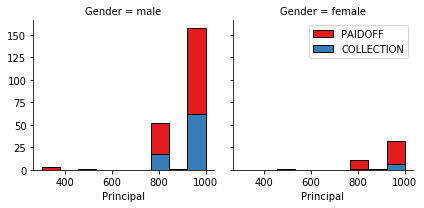

In [28]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

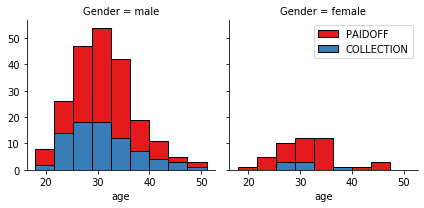

In [29]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

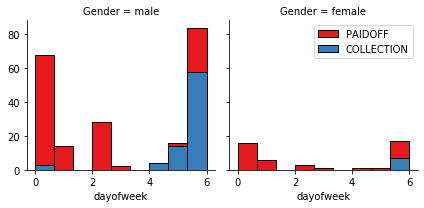

In [30]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [31]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [32]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [33]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [34]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [35]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [36]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [37]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [38]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [39]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [40]:
# The accuracy of the model depends on the train/test dataset size. Let's use test size of 0.2
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (276, 8) (276,)
Test set:  (70, 8) (70,)


In [65]:
# Obtaining the best k by evaluating from 1 to 60

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {'n_neighbors': np.arange(1, 10)}
knn = KNeighborsClassifier()

knn_grid = GridSearchCV(knn, param_grid,cv = 5, scoring='accuracy',iid = False)
knn_grid.fit(X_train,y_train)

y_tru, y_pre = y_test, knn_grid.predict(X_test)

print('Best parameter was found on development set:', knn_grid.best_params_ )
print('Accuracy:','%0.2f'% knn_grid.best_score_)
print()
print("Detailed classification report:")
print(classification_report(y_tru, y_pre))

Best parameter was found on development set: {'n_neighbors': 7}
Accuracy: 0.73

Detailed classification report:
              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

    accuracy                           0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


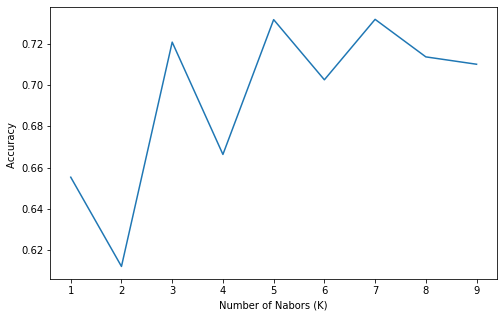

In [66]:
# # Plotting k vs accuracy
plt.figure(figsize = (8,5))
plt.plot(knn_grid.cv_results_['param_n_neighbors'], 
         knn_grid.cv_results_['mean_test_score']) 
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.show()

# Decision Tree

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [68]:
param_dist = {'criterion':['gini','entropy'],
             'min_samples_split':[2,5,10,20],
             'max_depth':[4,7,12,20],
             'min_samples_leaf':[1,5,10,20],
             'max_leaf_nodes': [2,5,10,20]}

# Using grid search to obtain best parameters
clf_grid = GridSearchCV(DecisionTreeClassifier(), 
                   param_dist, iid = False,
                   cv = 5, scoring='accuracy')
clf_grid.fit(X_train,y_train)

y_tr, y_pr = y_test, clf_grid.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [70]:
print('Best parameters set:', clf_grid.best_params_)
print('Accuracy:','%0.2f'% clf_grid.best_score_)
print()
print("Detailed classification report:")
print(classification_report(y_tr, y_pr))

Best parameters set: {'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.74

Detailed classification report:
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Support Vector Machine

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [72]:
tuned_parameters = {'kernel':['rbf','linear','sigmoid'], 'gamma':['scale','auto']}

svc_grid = GridSearchCV(SVC(), tuned_parameters, cv = 5, scoring = 'accuracy', iid = False)
svc_grid.fit(X_train,y_train)

y_tr, y_pr = y_test, svc_grid.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [74]:
print('Best parameters set:', svc_grid.best_params_)
print('Accuracy:','%0.2f'% svc_grid.best_score_)
print()
print("Detailed classification report:")
print(classification_report(y_tr, y_pr))

Best parameters set: {'gamma': 'scale', 'kernel': 'sigmoid'}
Accuracy: 0.73

Detailed classification report:
              precision    recall  f1-score   support

  COLLECTION       0.20      0.07      0.10        15
     PAIDOFF       0.78      0.93      0.85        55

    accuracy                           0.74        70
   macro avg       0.49      0.50      0.48        70
weighted avg       0.66      0.74      0.69        70



# Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

ylo = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0])
ylo = ylo.values.astype(int)

X_trn, X_tst, y_trn, y_tst = train_test_split(X, ylo, test_size = 0.2, random_state = 0)

In [76]:
parm = {'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
             'C':[0.01,0.001]}

LG_grid = GridSearchCV(LogisticRegression(), parm, cv = 10, scoring = 'accuracy', iid = False)
LG_grid.fit(X_trn,y_trn)

y_t, y_p = y_tst, LG_grid.predict(X_tst)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [77]:
print('Best parameters set:', LG_grid.best_params_)
print('Accuracy:','%0.2f'% LG_grid.best_score_)
# print()
# print("Detailed classification report:")
# print(classification_report(y_t, y_p))
print('Log Loss %0.2f' %log_loss(y_t, y_p))

Best parameters set: {'C': 0.01, 'solver': 'newton-cg'}
Accuracy: 0.73
Log Loss 5.92


# Model Evaluation using Test set

In [0]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [79]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-02-03 16:59:59--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-02-03 16:59:59 (738 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [80]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [81]:
# # Conver to date time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# Convert categorical features to numerical
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# One Hot Encoding and feature selection
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

# Independent variables
X_ev = Feature

# Dependent variables
y_ev = test_df['loan_status'].values

# Normalization of data
X_ev= preprocessing.StandardScaler().fit(X_ev).transform(X_ev)

print(X_ev[0:5])
print(y_ev[0:5])

[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]]
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [82]:
from sklearn.metrics import classification_report

#KNN Model Evaluation
print('KNN Model Evaluation')
y_etrue, y_epred = y_ev, knn_grid.predict(X_ev)

KNN = {'Jaccard':jaccard_similarity_score(y_etrue, y_epred),
       'F1 -score':f1_score(y_etrue, y_epred, average='weighted'),
       'LogLoss':'NA'}
print('-----------------------------------------')
print('Jaccard \t',
      'F1 Score \t',
      'Log Loss\n--------\t---------\t---------' )
print(' ''%0.2f'% KNN['Jaccard'],
      '\t\t ','%0.2f'% KNN['F1 -score'],
      '\t\t', KNN['LogLoss'] )
print()
print()

#Decision Tree Model Evaluation

print('Decision Model Evaluation')
print('-----------------------------------------')
from sklearn.metrics import classification_report
y_etru, y_epre = y_ev, clf_grid.predict(X_ev)

DecisionTree = {'Jaccard':jaccard_similarity_score(y_etru, y_epre),
                'F1 -score':f1_score(y_etru, y_epre, average='weighted'),
                'LogLoss':'NA'}

print('Jaccard \t',
      'F1 Score \t',
      'Log Loss\n--------\t---------\t---------' )
print(' ''%0.2f'% DecisionTree['Jaccard'],
      '\t\t ','%0.2f'% DecisionTree['F1 -score'],
      '\t\t', DecisionTree['LogLoss'] )
print()
print()

# SVM Model Evaluation
print('SVM Model Evaluation')
print('-----------------------------------------')
y_etr, y_epr = y_ev, svc_grid.predict(X_ev)

SVM = {'Jaccard':jaccard_similarity_score(y_etr, y_epr),
                'F1 -score':f1_score(y_etr, y_epr, average='weighted'),
                'LogLoss':'NA'}


print('Jaccard \t',
      'F1 Score \t',
      'Log Loss\n--------\t---------\t---------' )
print(' ''%0.2f'% SVM['Jaccard'],
      '\t\t ','%0.2f'% SVM['F1 -score'],
      '\t\t', SVM['LogLoss'] )
print()
print()

#Logistic Model Evaluatin
print('Logistic Regression Model Evaluatin')
print('------------------------------------------')
yl = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0])
yl = yl.values.astype(int) 

y_et, y_ep = yl, LG_grid.predict(X_ev)

LR = {'Jaccard':jaccard_similarity_score(y_et, y_ep),
                'F1 -score':f1_score(y_et, y_ep, average='weighted'),
                'LogLoss':log_loss(y_et, y_ep)}

print('Jaccard \t',
      'F1 Score \t',
      'Log Loss\n--------\t---------\t---------' )
print(' ''%0.2f'% LR['Jaccard'],
      '\t\t','%0.2f'% LR['F1 -score'],
      '\t\t','%0.2f'% LR['LogLoss'] )

KNN Model Evaluation
-----------------------------------------
Jaccard 	 F1 Score 	 Log Loss
--------	---------	---------
 0.67 		  0.63 		 NA


Decision Model Evaluation
-----------------------------------------
Jaccard 	 F1 Score 	 Log Loss
--------	---------	---------
 0.74 		  0.63 		 NA


SVM Model Evaluation
-----------------------------------------
Jaccard 	 F1 Score 	 Log Loss
--------	---------	---------
 0.70 		  0.64 		 NA


Logistic Regression Model Evaluatin
------------------------------------------
Jaccard 	 F1 Score 	 Log Loss
--------	---------	---------
 0.74 		 0.63 		 8.95


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/me

In [83]:
df1 = pd.DataFrame(KNN, index = ['KNN'])
df2 = pd.DataFrame(DecisionTree, index = ['Decision Tree'] )
df3 = pd.DataFrame(SVM, index = ['SVM'])
df4 = pd.DataFrame(LR, index = ['LinearRegression'])

frames = [df1, df2, df3,df4]

table = pd.concat(frames)
table.index.names = ['Algorithm']
pd.options.display.float_format = '{:.2f}'.format
print(table)

                  Jaccard  F1 -score LogLoss
Algorithm                                   
KNN                  0.67       0.63      NA
Decision Tree        0.74       0.63      NA
SVM                  0.70       0.64      NA
LinearRegression     0.74       0.63    8.95
